In [2]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [3]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## Settings

In [4]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 5 # TODO: to be tuned!

In [7]:
data_folder = Path("./data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [5]:
def preprocessing(mp3_tracks):
    for track in tqdm(mp3_tracks, total=N_TRACKS):
        convert_mp3_to_wav(str(track))

In [6]:
#preprocessing(mp3_tracks)

## Audio signals

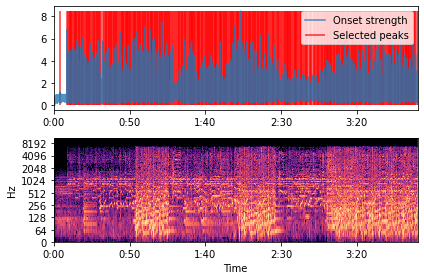

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 1:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        
        

/home/amedeo/Programmi/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


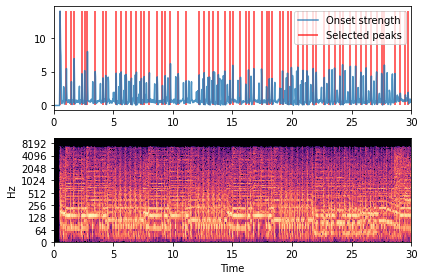

In [6]:
audio = "./data/mp3s-32k/aerosmith/Aerosmith/01-Make_It.mp3"
track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
plot_spectrogram_and_picks(track, sr, peaks, onset_env)

In [12]:
import pickle

In [9]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [13]:
save_object(onset_env, './data/onsetFisso.pkl')

## Minhash

In [9]:
# TODO

In [10]:
from bitstring import BitArray
import pandas as pd

In [11]:
def timeOfPeaks(peaks, times):
    timesPeaks = []
    
    for i in peaks:
        timesPeaks.append(times[i])
    
    return timesPeaks   

In [12]:
def fibonacci_hash_float(value:float):
    
    value = BitArray(float=value, length=64)
    phi = (1 + 5 ** 0.5) / 2
    g = int(2 ** 64 /phi)
    

    value ^= value >> 61
    value = int(g * value.float)
 
    return value

In [13]:
def minhash(freqs, times, threshold = None, duration = None):
    old_threshold = threshold
    f = 0
    out = []
    
    for i in range(0,duration//threshold):

        for fr, tm in zip(freqs,times):
            
            if(tm < threshold and tm > (threshold-old_threshold)):
            
                f += (fibonacci_hash_float(fr) + fibonacci_hash_float(tm))
                
            
        out.append(fibonacci_hash_float(f))    
        
        threshold += old_threshold
    
    out = np.min(out)
    
    return out    

In [14]:
def guess_song(song):
    hashtable = pd.read_csv("./data/hashtable_d240_t30.csv", index_col="hashid")
    track, sr, onset_env, peaks = load_audio_picks(song, DURATION, HOP_SIZE)
    times = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)
    timesPeaks = timeOfPeaks(peaks, times)
    freqsP = [onset_env[i] for i in peaks]
    h = minhash(freqsP, timesPeaks, THRESHOLD, DURATION)
    
    return (hashtable.loc[str(h)][0])

In [15]:
def make_hashtable():
    hashtable = []
    names = []
    data = pd.DataFrame()
    for idx, audio in tqdm(enumerate(tracks), total = N_TRACKS):
        names.append(audio)
        track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
        timess = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)

        timesPeaks = timeOfPeaks(peaks, timess)
        freqsP = [onset_env[i] for i in peaks]


        hashtable.append(minhash(freqsP, timesPeaks, THRESHOLD, DURATION))

    data['hashid'] = hashtable
    data['name'] = names
    data.to_csv('data/hashtable.csv', index=False)

In [16]:
#make_hashtable()

In [17]:
#data = pd.read_csv("./data/hashtable.csv", index_col="hashid")

Lets try with some test...

# Query test

take the fisrt query

In [18]:
audio = 'data/queries/track3.wav'

make the hashmin of the song

In [19]:
track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
timess = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE)
timesPeaks = timeOfPeaks(peaks, timess)
freqsP = [onset_env[i] for i in peaks]
    
h = minhash(freqsP, timesPeaks, THRESHOLD, DURATION)

lets see if it match something...

In [20]:
guess_song(audio)

'data/mp3s-32k/u2/October/07-October.wav'

In [21]:
data_folder2 = Path("./data/queries/")
query_tracks = data_folder2.glob("./*.wav")

In [22]:
get = 0
miss = 0
for query in query_tracks:
    print("\nCurrent query: " + str(query) + "\n")
    try:
        print(guess_song(query))
        get += 1
    except KeyError:
        print("Not matched!")
        miss += 1
    print("\n===========================================\n")
    
print("Song matched: " + str(get) + "  Song missed: " + str(miss))


Current query: data/queries/track10.wav

data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav



Current query: data/queries/track9.wav

data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav



Current query: data/queries/track4.wav

data/mp3s-32k/beatles/The_White_Album_Disc_1/04-Ob-La-Di_Ob-La-Da.wav



Current query: data/queries/track6.wav

data/mp3s-32k/led_zeppelin/Led_Zeppelin_II/05-Heartbreaker.wav



Current query: data/queries/track3.wav

data/mp3s-32k/u2/October/07-October.wav



Current query: data/queries/track2.wav

data/mp3s-32k/queen/The_Works/06-I_Want_To_Break_Free.wav



Current query: data/queries/track5.wav

data/mp3s-32k/radiohead/OK_Computer/06-Karma_Police.wav



Current query: data/queries/track7.wav

data/mp3s-32k/fleetwood_mac/Rumours/05-Go_Your_Own_Way.wav



Current query: data/queries/track8.wav

data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav



Current query: data/queries/track1.wav

data/mp3s-32k/aerosmith/Aerosmith/03-Dream_On.wa